# DA6401: Exploring Sequential learning using Deep Learning 
## MM21B010- Aravindan

## Visualizing the dataset

In [1]:
import pandas as pd

def load_and_print_entries_kaggle(base_path='/kaggle/input/dakshina-dataset1', num_samples=5):
    split_files = {
        'train': 'hi.translit.sampled.train.tsv',
        'dev': 'hi.translit.sampled.dev.tsv',
        'test': 'hi.translit.sampled.test.tsv'
    }

    for split, filename in split_files.items():
        filepath = f"{base_path}/{filename}"
        print(f"\n--- {split.upper()} SET ({filename}) ---")

        try:
            df = pd.read_csv(filepath, sep='\t', header=None, names=['devanagari', 'romanized', 'freq'])
            print(df[['romanized', 'devanagari']].head(num_samples).to_string(index=False))
        except Exception as e:
            print(f"Error loading {filename}: {e}")

# Run the function
load_and_print_entries_kaggle()


--- TRAIN SET (hi.translit.sampled.train.tsv) ---
romanized devanagari
       an         अं
 ankganit    अंकगणित
    uncle       अंकल
    ankur      अंकुर
  ankuran     अंकुरण

--- DEV SET (hi.translit.sampled.dev.tsv) ---
romanized devanagari
    ankan       अंकन
   angkor     अंगकोर
   angira     अंगिरा
  angithi     अंगीठी
   angrej    अंग्रेज

--- TEST SET (hi.translit.sampled.test.tsv) ---
romanized devanagari
      ank        अंक
     anka        अंक
    ankit      अंकित
   anakon      अंकों
   ankhon      अंकों


## Utility functions

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from collections import defaultdict

PAD_TOKEN = "<pad>"
SOS_TOKEN = "<sos>"
EOS_TOKEN = "<eos>"

def build_vocab(sequences):
    vocab = {PAD_TOKEN: 0, SOS_TOKEN: 1, EOS_TOKEN: 2}
    for seq in sequences:
        for char in seq:
            if char not in vocab:
                vocab[char] = len(vocab)
    return vocab

def encode_sequence(seq, vocab, add_special_tokens=True, max_len=None):
    indices = [vocab[c] for c in seq]
    if add_special_tokens:
        indices = [vocab[SOS_TOKEN]] + indices + [vocab[EOS_TOKEN]]
    if max_len:
        indices = indices[:max_len]
    return indices

def pad_sequence(seq, max_len, pad_idx):
    return seq + [pad_idx] * (max_len - len(seq))


In [3]:
class TransliterationDataset(Dataset):
    def __init__(self, df, src_vocab, tgt_vocab, max_len=30):
        self.df = df
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab
        self.max_len = max_len
        self.pad_idx = src_vocab[PAD_TOKEN]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        src_seq = encode_sequence(row['romanized'], self.src_vocab)
        tgt_seq = encode_sequence(row['devanagari'], self.tgt_vocab)
        src_seq = pad_sequence(src_seq, self.max_len, self.pad_idx)
        tgt_seq = pad_sequence(tgt_seq, self.max_len, self.pad_idx)
        return torch.tensor(src_seq), torch.tensor(tgt_seq)


In [4]:
def load_data(base_path='/kaggle/input/dakshina-dataset1', max_len=30, batch_size=32):
    import pandas as pd
    from torch.utils.data import DataLoader

    # from data_utils import TransliterationDataset, build_vocab  # or define inline

    # Load TSV files
    train_df = pd.read_csv(f"{base_path}/hi.translit.sampled.train.tsv", sep='\t', header=None, names=['devanagari', 'romanized', 'freq'])
    dev_df   = pd.read_csv(f"{base_path}/hi.translit.sampled.dev.tsv", sep='\t', header=None, names=['devanagari', 'romanized', 'freq'])

    # Drop rows with missing values
    train_df.dropna(inplace=True)
    dev_df.dropna(inplace=True)

    # Build vocabularies
    src_vocab = build_vocab(train_df['romanized'])
    tgt_vocab = build_vocab(train_df['devanagari'])

    # Create Datasets
    train_dataset = TransliterationDataset(train_df, src_vocab, tgt_vocab, max_len=max_len)
    dev_dataset   = TransliterationDataset(dev_df, src_vocab, tgt_vocab, max_len=max_len)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    dev_loader   = DataLoader(dev_dataset, batch_size=batch_size)

    return train_loader, dev_loader, src_vocab, tgt_vocab

## Model class

In [5]:
import torch
import torch.nn as nn

class Seq2SeqModel(nn.Module):
    def __init__(self, 
                 input_vocab_size, 
                 target_vocab_size, 
                 embedding_dim=64, 
                 hidden_size=128, 
                 encoder_layers=1, 
                 decoder_layers=1, 
                 cell_type='LSTM', 
                 dropout=0.2):
        super(Seq2SeqModel, self).__init__()

        self.embedding = nn.Embedding(input_vocab_size, embedding_dim)
        self.cell_type = cell_type.upper()
        rnn_cls = getattr(nn, self.cell_type)  # Choose RNN, GRU or LSTM

        self.encoder = rnn_cls(input_size=embedding_dim,
                               hidden_size=hidden_size,
                               num_layers=encoder_layers,
                               dropout=dropout if encoder_layers > 1 else 0,
                               batch_first=True)

        self.decoder = rnn_cls(input_size=embedding_dim,
                               hidden_size=hidden_size,
                               num_layers=decoder_layers,
                               dropout=dropout if decoder_layers > 1 else 0,
                               batch_first=True)

        self.output_fc = nn.Linear(hidden_size, target_vocab_size)
        self.target_embedding = nn.Embedding(target_vocab_size, embedding_dim)

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        # src: [B, T_in], trg: [B, T_out]
        batch_size, trg_len = trg.shape
        outputs = torch.zeros(batch_size, trg_len, self.output_fc.out_features).to(src.device)

        embedded_src = self.embedding(src)
        encoder_outputs, hidden = self.encoder(embedded_src)

        input_token = trg[:, 0]  # <sos> token

        # Initialize decoder hidden state from encoder
        decoder_hidden = hidden

        for t in range(1, trg_len):
            embedded_trg = self.target_embedding(input_token).unsqueeze(1)
            decoder_output, decoder_hidden = self.decoder(embedded_trg, decoder_hidden)
            output = self.output_fc(decoder_output.squeeze(1))
            outputs[:, t] = output

            top1 = output.argmax(1)
            input_token = trg[:, t] if torch.rand(1).item() < teacher_forcing_ratio else top1

        return outputs
    def predict(self, src, tgt_vocab, max_len=50):
        self.eval()
        batch_size = src.size(0)
        pad_idx = tgt_vocab["<pad>"]
        sos_idx = tgt_vocab["<sos>"]
        eos_idx = tgt_vocab["<eos>"]
    
        with torch.no_grad():
            embedded_src = self.embedding(src)
            encoder_outputs, hidden = self.encoder(embedded_src)
    
            input_token = torch.full((batch_size, 1), sos_idx, dtype=torch.long, device=src.device)
            outputs = []
    
            # for _ in range(max_len):
            #     embedded_input = self.target_embedding(input_token)
            #     decoder_output, hidden = self.decoder(embedded_input, hidden)
            #     top1 = decoder_output.argmax(2)  # [B, 1]
    
            #     # Clamp values to prevent out-of-range indexing
            #     top1 = torch.clamp(top1, max=self.target_embedding.num_embeddings - 1)
    
            #     outputs.append(top1.squeeze(1))
            #     input_token = top1
            for _ in range(max_len):
                embedded_input = self.target_embedding(input_token)
                decoder_output, hidden = self.decoder(embedded_input, hidden)
                logits = self.output_fc(decoder_output.squeeze(1))  # [B, V]
                top1 = logits.argmax(1, keepdim=True)               # [B, 1]
                outputs.append(top1.squeeze(1))
                input_token = top1

    
            outputs = torch.stack(outputs, dim=1)  # [B, T]
            return outputs

# Hyperparamter sweeps

In [6]:
sweep_config = {
    'method': 'random',  # or 'grid' or 'bayes'
    'metric': {
        'name': 'val_loss',
        'goal': 'minimize'
    },
    'parameters': {
        'embedding_dim': {
            'values': [16, 32, 64, 256]
        },
        'epochs': {
            'values': [5,10]
        },
        'hidden_size': {
            'values': [16, 32, 64, 256]
        },
        'encoder_layers': {
            'values': [1, 2, 3]
        },
        # 'decoder_layers': {
        #     'values': [1, 2, 3]
        # },
        # 'num_layers': {'values': [1, 2, 3]},
        'cell_type': {
            'values': ['RNN', 'GRU', 'LSTM']
        },
        'dropout': {
            'values': [0.2, 0.3]
        }
    }
}

# training block

In [6]:
import wandb
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

def calculate_accuracy(preds, targets, pad_idx):
    preds = preds.argmax(dim=-1)
    mask = targets != pad_idx
    correct = (preds == targets) & mask
    return correct.sum().item() / mask.sum().item()

def train(config=None):
    with wandb.init(config=config):
        config = wandb.config
        wandb.run.name = f"{config.cell_type}_epochs{config.epochs}_emb{config.embedding_dim}_hid{config.hidden_size}_enc{config.encoder_layers}_dec{config.encoder_layers}_do{int(config.dropout * 100)}"

        train_loader, dev_loader, src_vocab, tgt_vocab = load_data()
        input_vocab_size = len(src_vocab)
        target_vocab_size = len(tgt_vocab)

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        pad_idx = src_vocab["<pad>"]

        model = Seq2SeqModel(input_vocab_size=input_vocab_size,
                             target_vocab_size=target_vocab_size,
                             embedding_dim=config.embedding_dim,
                             hidden_size=config.hidden_size,
                             encoder_layers=config.encoder_layers,
                             decoder_layers=config.encoder_layers,
                             cell_type=config.cell_type,
                             dropout=config.dropout).to(device)

        optimizer = optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

        for epoch in range(config.epochs):
            model.train()
            total_loss = 0
            total_acc = 0
            progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=True)
            for src_batch, tgt_batch in progress_bar:
                src_batch, tgt_batch = src_batch.to(device), tgt_batch.to(device)
                optimizer.zero_grad()
                output = model(src_batch, tgt_batch)  # [B, T, V]
                loss = criterion(
                    output[:, 1:].reshape(-1, target_vocab_size),
                    tgt_batch[:, 1:].reshape(-1)
                )
                acc = calculate_accuracy(output[:, 1:], tgt_batch[:, 1:], pad_idx)

                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                total_acc += acc
                progress_bar.set_postfix(loss=loss.item(), acc=acc)

            avg_train_loss = total_loss / len(train_loader)
            avg_train_acc = total_acc / len(train_loader)

            # 🔍 Validation step
            model.eval()
            val_loss = 0
            val_acc = 0
            with torch.no_grad():
                for src_batch, tgt_batch in dev_loader:
                    src_batch, tgt_batch = src_batch.to(device), tgt_batch.to(device)
                    output = model(src_batch, tgt_batch)
                    loss = criterion(
                        output[:, 1:].reshape(-1, target_vocab_size),
                        tgt_batch[:, 1:].reshape(-1)
                    )
                    acc = calculate_accuracy(output[:, 1:], tgt_batch[:, 1:], pad_idx)
                    val_loss += loss.item()
                    val_acc += acc
            avg_val_loss = val_loss / len(dev_loader)
            avg_val_acc = val_acc / len(dev_loader)

            # 📊 Logging
            wandb.log({
                'epoch': epoch,
                'train_loss': avg_train_loss,
                'train_accuracy': avg_train_acc,
                'val_loss': avg_val_loss,
                'val_accuracy': avg_val_acc
            })

In [ ]:
# login only once at the start of notebook
wandb.login(key="011c3a6cd3743b4b10442ed458038feb25f78ad6")

# create sweep
sweep_id = wandb.sweep(sweep_config, project='dakshina-transliteration')

# launch agents (single or multiple)
wandb.agent(sweep_id, function=train, count=40)  # change count as needed

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mm21b010 (mm21b010-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Create sweep with ID: cf5zp1w4
Sweep URL: https://wandb.ai/mm21b010-indian-institute-of-technology-madras/dakshina-transliteration/sweeps/cf5zp1w4


wandb: Agent Starting Run: n7b1pffs with config:
wandb: 	cell_type: GRU
wandb: 	dropout: 0.3
wandb: 	embedding_dim: 16
wandb: 	encoder_layers: 3
wandb: 	epochs: 10
wandb: 	hidden_size: 64


Epoch 10: 100%|██████████| 1382/1382 [01:14<00:00, 18.46it/s, acc=0.712, loss=1.02] 


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▇▇▇███
train_loss,█▅▃▂▂▂▁▁▁▁
val_accuracy,▁▄▆▆▇▇▇███
val_loss,█▅▃▂▂▂▁▁▁▁
epoch,9
train_accuracy,0.7132
train_loss,0.93637
val_accuracy,0.74136
val_loss,0.87395


wandb: Agent Starting Run: hlmlzd1a with config:
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.2
wandb: 	embedding_dim: 256
wandb: 	encoder_layers: 3
wandb: 	epochs: 5
wandb: 	hidden_size: 256


Epoch 5: 100%|██████████| 1382/1382 [01:31<00:00, 15.11it/s, acc=0.848, loss=0.568]


epoch,▁▃▅▆█
train_accuracy,▁▅▇██
train_loss,█▃▂▁▁
val_accuracy,▁▆▇▇█
val_loss,█▃▂▁▁
epoch,4
train_accuracy,0.80123
train_loss,0.65965
val_accuracy,0.78088
val_loss,0.74048


wandb: Agent Starting Run: 74x9hsvr with config:
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.3
wandb: 	embedding_dim: 64
wandb: 	encoder_layers: 3
wandb: 	epochs: 10
wandb: 	hidden_size: 64


Epoch 10: 100%|██████████| 1382/1382 [01:22<00:00, 16.83it/s, acc=0.587, loss=1.09] 


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▄▆▇▇▇███
train_loss,█▆▄▃▂▂▂▁▁▁
val_accuracy,▁▃▅▆▇▇████
val_loss,█▆▄▂▂▂▁▁▁▁
epoch,9
train_accuracy,0.71354
train_loss,0.94283
val_accuracy,0.73809
val_loss,0.8738


wandb: Agent Starting Run: e451fvvc with config:
wandb: 	cell_type: RNN
wandb: 	dropout: 0.3
wandb: 	embedding_dim: 256
wandb: 	encoder_layers: 1
wandb: 	epochs: 5
wandb: 	hidden_size: 64


Epoch 5: 100%|██████████| 1382/1382 [00:48<00:00, 28.62it/s, acc=0.23, loss=2.91] 


epoch,▁▃▅▆█
train_accuracy,▁▆▇▇█
train_loss,█▃▂▁▁
val_accuracy,▄▁▆█▆
val_loss,█▅▁▂▃
epoch,4
train_accuracy,0.23113
train_loss,2.89297
val_accuracy,0.22299
val_loss,2.93403


wandb: Agent Starting Run: ynyo480k with config:
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.3
wandb: 	embedding_dim: 256
wandb: 	encoder_layers: 3
wandb: 	epochs: 10
wandb: 	hidden_size: 16


Epoch 10: 100%|██████████| 1382/1382 [01:22<00:00, 16.80it/s, acc=0.493, loss=2.04]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▅▆▆▇▇█
train_loss,█▆▅▄▄▃▂▂▁▁
val_accuracy,▁▂▃▄▄▅▆▆▇█
val_loss,█▇▆▅▄▄▃▂▂▁
epoch,9
train_accuracy,0.36987
train_loss,2.24604
val_accuracy,0.39627
val_loss,2.13031


wandb: Agent Starting Run: lxim8imy with config:
wandb: 	cell_type: RNN
wandb: 	dropout: 0.3
wandb: 	embedding_dim: 16
wandb: 	encoder_layers: 1
wandb: 	epochs: 10
wandb: 	hidden_size: 256


Epoch 10: 100%|██████████| 1382/1382 [00:49<00:00, 28.15it/s, acc=0.311, loss=2.65]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▆▇█▇██
train_loss,█▅▄▃▂▂▂▂▁▁
val_accuracy,▁▆▆▅▇▄▆█▇▅
val_loss,█▄▃▃▂▅▂▁▂▃
epoch,9
train_accuracy,0.23452
train_loss,2.86159
val_accuracy,0.21751
val_loss,2.95079


wandb: Agent Starting Run: g8rcj4b6 with config:
wandb: 	cell_type: GRU
wandb: 	dropout: 0.3
wandb: 	embedding_dim: 32
wandb: 	encoder_layers: 3
wandb: 	epochs: 10
wandb: 	hidden_size: 64


Epoch 10: 100%|██████████| 1382/1382 [01:15<00:00, 18.20it/s, acc=0.722, loss=0.915]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▆▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▄▅▆▇▇▇███
val_loss,█▅▃▃▂▂▁▁▁▁
epoch,9
train_accuracy,0.69013
train_loss,1.01158
val_accuracy,0.71313
val_loss,0.95486


wandb: Agent Starting Run: 2mtph1pa with config:
wandb: 	cell_type: GRU
wandb: 	dropout: 0.3
wandb: 	embedding_dim: 256
wandb: 	encoder_layers: 3
wandb: 	epochs: 10
wandb: 	hidden_size: 32


Epoch 10: 100%|██████████| 1382/1382 [01:16<00:00, 18.17it/s, acc=0.492, loss=1.56]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▅▆▇▇▇██
train_loss,█▅▄▃▃▂▂▁▁▁
val_accuracy,▁▃▄▅▆▆▇▇██
val_loss,█▆▄▃▃▂▂▁▁▁
epoch,9
train_accuracy,0.55782
train_loss,1.47766
val_accuracy,0.61038
val_loss,1.32271


wandb: Agent Starting Run: ijvm6rhp with config:
wandb: 	cell_type: RNN
wandb: 	dropout: 0.2
wandb: 	embedding_dim: 256
wandb: 	encoder_layers: 1
wandb: 	epochs: 10
wandb: 	hidden_size: 32


Epoch 10: 100%|██████████| 1382/1382 [00:48<00:00, 28.45it/s, acc=0.236, loss=2.95]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▇▇▇▇██▇█
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▂▁▄▄▅█▄▅▃▆
val_loss,█▇▆▄▄▂▄▂▄▁
epoch,9
train_accuracy,0.22775
train_loss,2.91357
val_accuracy,0.22285
val_loss,2.93005


wandb: Agent Starting Run: s29ox54e with config:
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.2
wandb: 	embedding_dim: 16
wandb: 	encoder_layers: 2
wandb: 	epochs: 10
wandb: 	hidden_size: 16


Epoch 10: 100%|██████████| 1382/1382 [01:09<00:00, 19.94it/s, acc=0.314, loss=2.17]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▄▅▅▆▇▇█
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▂▃▄▄▅▆▆▇█
val_loss,█▆▅▄▃▃▂▂▂▁
epoch,9
train_accuracy,0.3424
train_loss,2.44716
val_accuracy,0.35101
val_loss,2.39274


wandb: Agent Starting Run: qmb7ed10 with config:
wandb: 	cell_type: GRU
wandb: 	dropout: 0.2
wandb: 	embedding_dim: 32
wandb: 	encoder_layers: 2
wandb: 	epochs: 10
wandb: 	hidden_size: 64


Epoch 10: 100%|██████████| 1382/1382 [01:05<00:00, 21.06it/s, acc=0.71, loss=0.853] 


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▇▇▇███
train_loss,█▅▃▃▂▂▂▁▁▁
val_accuracy,▁▄▅▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,9
train_accuracy,0.71436
train_loss,0.94121
val_accuracy,0.7164
val_loss,0.94845


wandb: Agent Starting Run: zrt770p9 with config:
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.3
wandb: 	embedding_dim: 32
wandb: 	encoder_layers: 1
wandb: 	epochs: 5
wandb: 	hidden_size: 16


Epoch 5: 100%|██████████| 1382/1382 [00:55<00:00, 24.84it/s, acc=0.213, loss=3.01]


epoch,▁▃▅▆█
train_accuracy,▁▅▆▇█
train_loss,█▄▃▂▁
val_accuracy,▁▂▄▇█
val_loss,█▇▅▂▁
epoch,4
train_accuracy,0.28914
train_loss,2.64733
val_accuracy,0.28578
val_loss,2.65062


wandb: Agent Starting Run: m1h5h9t0 with config:
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.2
wandb: 	embedding_dim: 16
wandb: 	encoder_layers: 1
wandb: 	epochs: 10
wandb: 	hidden_size: 32


Epoch 4:  51%|█████     | 702/1382 [00:28<00:27, 24.51it/s, acc=0.304, loss=2.6] 

In [ ]:
wandb.finish()

In [7]:
sweep_config = {
    'method': 'random',  # or 'grid' or 'bayes'
    'metric': {
        'name': 'val_loss',
        'goal': 'minimize'
    },
    'parameters': {
        'embedding_dim': {
            'values': [16, 32]
        },
        'epochs': {
            'values': [10]
        },
        'hidden_size': {
            'values': [64, 256]
        },
        'encoder_layers': {
            'values': [2, 3]
        },
        # 'decoder_layers': {
        #     'values': [1, 2, 3]
        # },
        # 'num_layers': {'values': [1, 2, 3]},
        'cell_type': {
            'values': ['GRU', 'LSTM']
        },
        'dropout': {
            'values': [0.24, 0.31]
        }
    }
}

In [ ]:
# login only once at the start of notebook
wandb.login(key="011c3a6cd3743b4b10442ed458038feb25f78ad6")

# create sweep
sweep_id = wandb.sweep(sweep_config, project='dakshina-transliteration')

# launch agents (single or multiple)
wandb.agent(sweep_id, function=train, count=10)  # change count as needed
wandb.finish()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mm21b010 (mm21b010-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Create sweep with ID: 76v8usa3
Sweep URL: https://wandb.ai/mm21b010-indian-institute-of-technology-madras/dakshina-transliteration/sweeps/76v8usa3


wandb: Agent Starting Run: a9ptnb8a with config:
wandb: 	cell_type: GRU
wandb: 	dropout: 0.31
wandb: 	embedding_dim: 16
wandb: 	encoder_layers: 3
wandb: 	epochs: 10
wandb: 	hidden_size: 64


Epoch 10: 100%|██████████| 1382/1382 [01:15<00:00, 18.26it/s, acc=0.73, loss=0.766] 


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▆▆▇▇▇███
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▄▆▆▇▇████
val_loss,█▄▃▂▂▂▁▁▁▁
epoch,9
train_accuracy,0.71527
train_loss,0.92823
val_accuracy,0.74166
val_loss,0.85787


wandb: Agent Starting Run: hs1zvh04 with config:
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.24
wandb: 	embedding_dim: 32
wandb: 	encoder_layers: 2
wandb: 	epochs: 10
wandb: 	hidden_size: 256


Epoch 10: 100%|██████████| 1382/1382 [01:16<00:00, 18.11it/s, acc=0.817, loss=0.566]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▆▇▇████
train_loss,█▆▃▂▂▂▁▁▁▁
val_accuracy,▁▅▇███████
val_loss,█▄▂▁▁▁▁▁▁▁
epoch,9
train_accuracy,0.88426
train_loss,0.38598
val_accuracy,0.79026
val_loss,0.75867


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: est2leij with config:
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.24
wandb: 	embedding_dim: 16
wandb: 	encoder_layers: 3
wandb: 	epochs: 10
wandb: 	hidden_size: 256


Epoch 10: 100%|██████████| 1382/1382 [01:41<00:00, 13.58it/s, acc=0.87, loss=0.54]  


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▆▇▇▇██
train_loss,█▆▅▄▃▂▂▁▁▁
val_accuracy,▁▃▄▅▆▇▇███
val_loss,█▆▅▄▂▂▂▁▁▁
epoch,9
train_accuracy,0.80793
train_loss,0.64018
val_accuracy,0.76633
val_loss,0.7943


wandb: Agent Starting Run: drvwsgy5 with config:
wandb: 	cell_type: GRU
wandb: 	dropout: 0.31
wandb: 	embedding_dim: 32
wandb: 	encoder_layers: 2
wandb: 	epochs: 10
wandb: 	hidden_size: 64


Epoch 10: 100%|██████████| 1382/1382 [01:06<00:00, 20.64it/s, acc=0.676, loss=1.03] 


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▆▆▇▇▇██
train_loss,█▅▄▃▃▂▂▁▁▁
val_accuracy,▁▃▅▆▆▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,9
train_accuracy,0.67564
train_loss,1.07187
val_accuracy,0.68381
val_loss,1.05246


wandb: Agent Starting Run: mm4h1vlz with config:
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.24
wandb: 	embedding_dim: 16
wandb: 	encoder_layers: 3
wandb: 	epochs: 10
wandb: 	hidden_size: 64


Epoch 10: 100%|██████████| 1382/1382 [01:28<00:00, 15.60it/s, acc=0.574, loss=1.51] 


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▄▅▆▇▇███
train_loss,█▇▅▄▃▂▂▁▁▁
val_accuracy,▁▂▄▆▇▇████
val_loss,█▆▄▃▂▂▁▁▁▁
epoch,9
train_accuracy,0.70017
train_loss,1.00108
val_accuracy,0.7165
val_loss,0.9569


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: itc44axd with config:
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.24
wandb: 	embedding_dim: 32
wandb: 	encoder_layers: 3
wandb: 	epochs: 10
wandb: 	hidden_size: 256


Epoch 5:  97%|█████████▋| 1342/1382 [01:35<00:02, 13.93it/s, acc=0.74, loss=0.873] 

# training the optimal model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset
import pandas as pd
from tqdm import tqdm
import os

# Assume these are defined elsewhere
# from model import Seq2SeqModel
# from data_loader import TransliterationDataset, build_vocab, encode_sequence, pad_sequence, load_kaggle_data

# Define best hyperparameters (from sweep results)
best_config = {
    'embedding_dim': 32,
    'hidden_size': 256,
    'encoder_layers': 3,
    'decoder_layers': 3,
    'cell_type': 'LSTM',
    'dropout': 0.3,
    'epochs': 10,
    'batch_size': 32
}

# Load and combine data
def load_combined_data():
    base_path = r"/kaggle/input/dakshina-dataset1"
    train_df = pd.read_csv(f'{base_path}/hi.translit.sampled.train.tsv', sep='\t', header=None, names=['devanagari', 'romanized', 'freq'])
    val_df = pd.read_csv(f'{base_path}/hi.translit.sampled.dev.tsv', sep='\t', header=None, names=['devanagari', 'romanized', 'freq'])
    test_df = pd.read_csv(f'{base_path}/hi.translit.sampled.test.tsv', sep='\t', header=None, names=['devanagari', 'romanized', 'freq'])

    # Combine and clean data
    combined_df = pd.concat([train_df, val_df], ignore_index=True)
    combined_df.dropna(subset=['romanized', 'devanagari'], inplace=True)
    test_df.dropna(subset=['romanized', 'devanagari'], inplace=True)  # Just in case
    train_df.dropna(subset=['romanized', 'devanagari'], inplace=True)
    # src_vocab = build_vocab(combined_df['romanized'])
    # tgt_vocab = build_vocab(combined_df['devanagari'])
    src_vocab = build_vocab(train_df['romanized'])  # ONLY training
    tgt_vocab = build_vocab(train_df['devanagari'])  # ONLY training

    train_dataset = TransliterationDataset(combined_df, src_vocab, tgt_vocab)
    test_dataset = TransliterationDataset(test_df, src_vocab, tgt_vocab)

    train_loader = DataLoader(train_dataset, batch_size=best_config['batch_size'], shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=best_config['batch_size'])

    return train_loader, test_loader, src_vocab, tgt_vocab, test_df


# Accuracy function
def compute_accuracy(preds, targets):
    match = 0
    total = 0
    for pred, tgt in zip(preds, targets):
        if pred == tgt:
            match += 1
        total += 1
    return match / total

# Evaluation and prediction
def evaluate(model, data_loader, tgt_vocab, device):
    model.eval()
    idx_to_char = {i: c for c, i in tgt_vocab.items()}
    predictions = []
    targets = []

    pad_idx = tgt_vocab["<pad>"]
    sos_idx = tgt_vocab["<sos>"]
    eos_idx = tgt_vocab["<eos>"]

    with torch.no_grad():
        for src_batch, tgt_batch in tqdm(data_loader, desc="Evaluating"):
            src_batch = src_batch.to(device)
            tgt_batch = tgt_batch.to(device)

            # Use model's predict method
            predicted_indices = model.predict(src_batch, tgt_vocab, max_len=tgt_batch.shape[1])

            # Decode predicted and target sequences
            for pred_seq, tgt_seq in zip(predicted_indices, tgt_batch):
                pred_str = ''.join([idx_to_char[idx.item()] for idx in pred_seq if idx.item() not in [pad_idx, sos_idx, eos_idx]])
                tgt_str = ''.join([idx_to_char[idx.item()] for idx in tgt_seq if idx.item() not in [pad_idx, sos_idx, eos_idx]])
                predictions.append(pred_str)
                targets.append(tgt_str)

    acc = compute_accuracy(predictions, targets)
    return predictions, targets, acc


# Train the best model and evaluate
def run_final_training():
    train_loader, test_loader, src_vocab, tgt_vocab, test_df = load_combined_data()
    input_vocab_size = len(src_vocab)
    target_vocab_size = len(tgt_vocab)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = Seq2SeqModel(input_vocab_size=input_vocab_size,
                         target_vocab_size=target_vocab_size,
                         embedding_dim=best_config['embedding_dim'],
                         hidden_size=best_config['hidden_size'],
                         encoder_layers=best_config['encoder_layers'],
                         decoder_layers=best_config['decoder_layers'],
                         cell_type=best_config['cell_type'],
                         dropout=best_config['dropout']).to(device)

    optimizer = optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss(ignore_index=src_vocab["<pad>"])

    model.train()
    for epoch in range(best_config['epochs']):
        total_loss = 0
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}")
        for src_batch, tgt_batch in loop:
            src_batch, tgt_batch = src_batch.to(device), tgt_batch.to(device)
            optimizer.zero_grad()
            output = model(src_batch, tgt_batch)
            loss = criterion(output[:, 1:].reshape(-1, target_vocab_size), tgt_batch[:, 1:].reshape(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        print(f"Epoch {epoch+1} avg loss: {total_loss / len(train_loader):.4f}")

    # Save model
    os.makedirs("models", exist_ok=True)
    torch.save(model.state_dict(), "models/best_model.pth")
    print("Model saved to models/best_model.pth")

    # Evaluate
    predictions, targets, test_acc = evaluate(model, test_loader, tgt_vocab, device)
    print(f"Test Accuracy: {test_acc:.4f}")

    # Save predictions
    os.makedirs("predictions_vanilla", exist_ok=True)
    out_df = pd.DataFrame({
        "Input (Romanized)": test_df['romanized'],
        "Target (Devanagari)": test_df['devanagari'],
        "Prediction": predictions
    })
    out_df.to_csv("predictions_vanilla/test_predictions.tsv", sep="\t", index=False)
    print("Predictions saved to predictions_vanilla/test_predictions.tsv")

    # Sample visualization
    print("\nSample Predictions:")
    print(out_df.sample(10).to_markdown(index=False))

# Run the final training and evaluation
run_final_training()

In [10]:
train_loader, test_loader, src_vocab, tgt_vocab, test_df = load_combined_data()
print(tgt_vocab)

{'<pad>': 0, '<sos>': 1, '<eos>': 2, 'अ': 3, 'ं': 4, 'क': 5, 'ग': 6, 'ण': 7, 'ि': 8, 'त': 9, 'ल': 10, 'ु': 11, 'र': 12, 'श': 13, 'द': 14, 'न': 15, 'े': 16, 'भ': 17, '्': 18, 'ष': 19, 'ा': 20, 'ी': 21, 'ठ': 22, 'य': 23, 'ो': 24, 'ू': 25, 'ज': 26, 'च': 27, 'म': 28, 'ट': 29, 'ड': 30, 'व': 31, 'ः': 32, 'ह': 33, 'प': 34, 'ृ': 35, 'स': 36, 'ध': 37, 'ै': 38, '़': 39, 'ब': 40, 'उ': 41, 'ॉ': 42, 'ई': 43, 'ख': 44, 'घ': 45, 'छ': 46, 'ञ': 47, 'फ': 48, 'ओ': 49, 'थ': 50, 'ढ': 51, 'झ': 52, 'ौ': 53, 'आ': 54, 'इ': 55, 'ँ': 56, 'ए': 57, 'ऊ': 58, 'ॅ': 59, 'ऋ': 60, 'ऑ': 61, 'ऐ': 62, 'औ': 63, 'ङ': 64, 'ॐ': 65}


In [11]:
train_loader, dev_loader, src_vocab, tgt_vocab2=load_data()
print( tgt_vocab2==tgt_vocab)

True


## Test set predctions on the saved model

In [16]:
def run_inference_only():
    _, test_loader, src_vocab, tgt_vocab, test_df = load_combined_data()
    input_vocab_size = len(src_vocab)
    target_vocab_size = len(tgt_vocab)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize model with same architecture
    model = Seq2SeqModel(input_vocab_size=input_vocab_size,
                         target_vocab_size=target_vocab_size,
                         embedding_dim=best_config['embedding_dim'],
                         hidden_size=best_config['hidden_size'],
                         encoder_layers=best_config['encoder_layers'],
                         decoder_layers=best_config['decoder_layers'],
                         cell_type=best_config['cell_type'],
                         dropout=best_config['dropout']).to(device)

    # Load pre-trained weights
    model.load_state_dict(torch.load("/kaggle/input/lstm_transiliteration/pytorch/default/1/best_model.pth", map_location=device))
    print("✅ Loaded model weights from models/best_model.pth")

    # Run evaluation and prediction
    predictions, targets, test_acc = evaluate(model, test_loader, tgt_vocab, device)
    print(f"Test Accuracy: {test_acc:.4f}")

    # Save predictions
    os.makedirs("predictions_vanilla", exist_ok=True)
    out_df = pd.DataFrame({
        "Input (Romanized)": test_df['romanized'],
        "Target (Devanagari)": test_df['devanagari'],
        "Prediction": predictions
    })
    out_df.to_csv("predictions_vanilla/test_predictions.tsv", sep="\t", index=False)
    print("📄 Predictions saved to predictions_vanilla/test_predictions.tsv")

    # Sample visualization
    print("\n🔍 Sample Predictions:")
    print(out_df.sample(10).to_markdown(index=False))
run_inference_only()

✅ Loaded model weights from models/best_model.pth


Evaluating: 100%|██████████| 141/141 [00:05<00:00, 24.03it/s]

Test Accuracy: 0.3836
📄 Predictions saved to predictions_vanilla/test_predictions.tsv

🔍 Sample Predictions:
| Input (Romanized)   | Target (Devanagari)   | Prediction   |
|:--------------------|:----------------------|:-------------|
| vlad                | व्लाद                   | व्लाद          |
| sataane             | सताने                   | सताने          |
| pisa                | पीसा                    | पिसा           |
| lagega              | लगेगा                   | लगेगा          |
| shanivar            | शनिवार                  | शानिवार         |
| masaledar           | मसालेदार                 | मसालेडर        |
| hamala              | हमला                   | हमला          |
| corridor            | कोरिडोर                  | कॉरिसर         |
| dolne               | डोलने                   | डोलने          |
| nandanvan           | नंदनवन                 | नंदनवान        |


## Attention based modelling

In [7]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.attn = nn.Linear(hidden_size * 2, hidden_size)
        self.v = nn.Parameter(torch.rand(hidden_size))

    def forward(self, hidden, encoder_outputs, mask=None):
        # hidden: [B, H], encoder_outputs: [B, T, H]
        T = encoder_outputs.size(1)
        hidden = hidden.unsqueeze(1).repeat(1, T, 1)  # [B, T, H]
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))  # [B, T, H]
        energy = energy @ self.v  # [B, T]
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        attn_weights = torch.softmax(energy, dim=1)  # [B, T]
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs)  # [B, 1, H]
        return context, attn_weights

In [8]:
class AttnSeq2SeqModel(nn.Module):
    def __init__(self, input_vocab_size, target_vocab_size, embedding_dim, hidden_size, cell_type='LSTM', dropout=0.2):
        super().__init__()
        self.cell_type = cell_type.upper()
        rnn_cls = getattr(nn, self.cell_type)

        self.embedding = nn.Embedding(input_vocab_size, embedding_dim)
        self.target_embedding = nn.Embedding(target_vocab_size, embedding_dim)

        self.encoder = rnn_cls(embedding_dim, hidden_size, batch_first=True)
        self.decoder = rnn_cls(embedding_dim + hidden_size, hidden_size, batch_first=True)
        self.attention = Attention(hidden_size)
        self.fc_out = nn.Linear(hidden_size * 2, target_vocab_size)

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        device = src.device
        batch_size, trg_len = trg.shape
        target_vocab_size = self.fc_out.out_features

        outputs = torch.zeros(batch_size, trg_len, target_vocab_size).to(device)

        embedded_src = self.embedding(src)
        encoder_outputs, hidden = self.encoder(embedded_src)  # [B, T, H]

        if self.cell_type == 'LSTM':
            decoder_hidden = (hidden[0], hidden[1])  # (h, c)
        else:
            decoder_hidden = hidden

        input_token = trg[:, 0]
        for t in range(1, trg_len):
            embedded_trg = self.target_embedding(input_token).unsqueeze(1)  # [B, 1, E]

            if self.cell_type == 'LSTM':
                context, _ = self.attention(decoder_hidden[0][-1], encoder_outputs)
            else:
                context, _ = self.attention(decoder_hidden[-1], encoder_outputs)

            rnn_input = torch.cat((embedded_trg, context), dim=2)  # [B, 1, E+H]
            decoder_output, decoder_hidden = self.decoder(rnn_input, decoder_hidden)  # [B, 1, H]
            output = self.fc_out(torch.cat((decoder_output.squeeze(1), context.squeeze(1)), dim=1))  # [B, V]
            outputs[:, t] = output

            top1 = output.argmax(1)
            input_token = trg[:, t] if torch.rand(1).item() < teacher_forcing_ratio else top1

        return outputs
        
    def predict(self, src, tgt_vocab, max_len=50):
        self.eval()
        batch_size = src.size(0)
        pad_idx = tgt_vocab["<pad>"]
        sos_idx = tgt_vocab["<sos>"]
        eos_idx = tgt_vocab["<eos>"]
    
        with torch.no_grad():
            embedded_src = self.embedding(src)
            encoder_outputs, hidden = self.encoder(embedded_src)
    
            input_token = torch.full((batch_size,), sos_idx, dtype=torch.long, device=src.device)
            outputs = []
    
            if self.cell_type == 'LSTM':
                decoder_hidden = (hidden[0], hidden[1])
            else:
                decoder_hidden = hidden
    
            for _ in range(max_len):
                embedded_input = self.target_embedding(input_token).unsqueeze(1)  # [B, 1, E]
                if self.cell_type == 'LSTM':
                    context, _ = self.attention(decoder_hidden[0][-1], encoder_outputs)
                else:
                    context, _ = self.attention(decoder_hidden[-1], encoder_outputs)
    
                rnn_input = torch.cat((embedded_input, context), dim=2)  # [B, 1, E+H]
                decoder_output, decoder_hidden = self.decoder(rnn_input, decoder_hidden)
                logits = self.fc_out(torch.cat((decoder_output.squeeze(1), context.squeeze(1)), dim=1))  # [B, V]
                top1 = logits.argmax(1)
                outputs.append(top1)
                input_token = top1
    
            outputs = torch.stack(outputs, dim=1)  # [B, T]
            return outputs
    def predict_with_attention(self, src, tgt_vocab, max_len=50):
        self.eval()
        batch_size = src.size(0)
        pad_idx = tgt_vocab["<pad>"]
        sos_idx = tgt_vocab["<sos>"]
        eos_idx = tgt_vocab["<eos>"]
    
        all_attn_weights = []  # NEW
        outputs = []
    
        with torch.no_grad():
            embedded_src = self.embedding(src)
            encoder_outputs, hidden = self.encoder(embedded_src)
    
            input_token = torch.full((batch_size,), sos_idx, dtype=torch.long, device=src.device)
    
            if self.cell_type == 'LSTM':
                decoder_hidden = (hidden[0], hidden[1])
            else:
                decoder_hidden = hidden
    
            for _ in range(max_len):
                embedded_input = self.target_embedding(input_token).unsqueeze(1)
                if self.cell_type == 'LSTM':
                    context, attn_weights = self.attention(decoder_hidden[0][-1], encoder_outputs)
                else:
                    context, attn_weights = self.attention(decoder_hidden[-1], encoder_outputs)
    
                all_attn_weights.append(attn_weights.squeeze(1))  # [B, S]
    
                rnn_input = torch.cat((embedded_input, context), dim=2)
                decoder_output, decoder_hidden = self.decoder(rnn_input, decoder_hidden)
    
                logits = self.fc_out(torch.cat((decoder_output.squeeze(1), context.squeeze(1)), dim=1))
                top1 = logits.argmax(1)
                outputs.append(top1)
                input_token = top1
    
            outputs = torch.stack(outputs, dim=1)  # [B, T]
            attn_tensor = torch.stack(all_attn_weights, dim=1)  # [B, T, S]
            return outputs, attn_tensor


In [9]:
import wandb
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

def calculate_accuracy(preds, targets, pad_idx):
    preds = preds.argmax(dim=-1)
    mask = targets != pad_idx
    correct = (preds == targets) & mask
    return correct.sum().item() / mask.sum().item()

def train(config=None):
    with wandb.init(config=config):
        config = wandb.config
        wandb.run.name = f"{config.cell_type}_epochs{config.epochs}_emb{config.embedding_dim}_hid{config.hidden_size}_enc{config.encoder_layers}_dec{config.encoder_layers}_do{int(config.dropout * 100)}"

        train_loader, dev_loader, src_vocab, tgt_vocab = load_data()
        input_vocab_size = len(src_vocab)
        target_vocab_size = len(tgt_vocab)

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        pad_idx = src_vocab["<pad>"]

        
        model = AttnSeq2SeqModel(
            input_vocab_size=input_vocab_size,
            target_vocab_size=target_vocab_size,
            embedding_dim=config.embedding_dim,
            hidden_size=config.hidden_size,
            cell_type=config.cell_type,
            dropout=config.dropout
        ).to(device)

        optimizer = optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

        for epoch in range(config.epochs):
            model.train()
            total_loss = 0
            total_acc = 0
            progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=True)
            for src_batch, tgt_batch in progress_bar:
                src_batch, tgt_batch = src_batch.to(device), tgt_batch.to(device)
                optimizer.zero_grad()
                output = model(src_batch, tgt_batch)  # [B, T, V]
                loss = criterion(
                    output[:, 1:].reshape(-1, target_vocab_size),
                    tgt_batch[:, 1:].reshape(-1)
                )
                acc = calculate_accuracy(output[:, 1:], tgt_batch[:, 1:], pad_idx)

                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                total_acc += acc
                progress_bar.set_postfix(loss=loss.item(), acc=acc)

            avg_train_loss = total_loss / len(train_loader)
            avg_train_acc = total_acc / len(train_loader)

            # 🔍 Validation step
            model.eval()
            val_loss = 0
            val_acc = 0
            with torch.no_grad():
                for src_batch, tgt_batch in dev_loader:
                    src_batch, tgt_batch = src_batch.to(device), tgt_batch.to(device)
                    output = model(src_batch, tgt_batch)
                    loss = criterion(
                        output[:, 1:].reshape(-1, target_vocab_size),
                        tgt_batch[:, 1:].reshape(-1)
                    )
                    acc = calculate_accuracy(output[:, 1:], tgt_batch[:, 1:], pad_idx)
                    val_loss += loss.item()
                    val_acc += acc
            avg_val_loss = val_loss / len(dev_loader)
            avg_val_acc = val_acc / len(dev_loader)

            # 📊 Logging
            wandb.log({
                'epoch': epoch,
                'train_loss': avg_train_loss,
                'train_accuracy': avg_train_acc,
                'val_loss': avg_val_loss,
                'val_accuracy': avg_val_acc
            })



In [21]:
sweep_config = {
    'method': 'random',  # or 'grid' or 'bayes'
    'metric': {
        'name': 'val_loss',
        'goal': 'minimize'
    },
    'parameters': {
        'embedding_dim': {
            'values': [16, 32]
        },
        'epochs': {
            'values': [10]
        },
        'hidden_size': {
            'values': [64, 256]
        },
        'encoder_layers': {
            'values': [2, 3]
        },
        # 'decoder_layers': {
        #     'values': [1, 2, 3]
        # },
        # 'num_layers': {'values': [1, 2, 3]},
        'cell_type': {
            'values': ['GRU', 'LSTM']
        },
        'dropout': {
            'values': [0.24, 0.31]
        }
    }
}

In [22]:
# login only once at the start of notebook
wandb.login(key="011c3a6cd3743b4b10442ed458038feb25f78ad6")

# create sweep
sweep_id = wandb.sweep(sweep_config, project='dakshina-transliteration')

# launch agents (single or multiple)
wandb.agent(sweep_id, function=train, count=20)  # change count as needed
wandb.finish()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mm21b010 (mm21b010-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Create sweep with ID: 9tg1us73
Sweep URL: https://wandb.ai/mm21b010-indian-institute-of-technology-madras/dakshina-transliteration/sweeps/9tg1us73


wandb: Agent Starting Run: yxbvriw9 with config:
wandb: 	cell_type: GRU
wandb: 	dropout: 0.24
wandb: 	embedding_dim: 32
wandb: 	encoder_layers: 2
wandb: 	epochs: 10
wandb: 	hidden_size: 256


Epoch 10: 100%|██████████| 1382/1382 [01:39<00:00, 13.93it/s, acc=0.947, loss=0.172]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▇▇▇███
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▅▇▇▇█▇▇▇▇
val_loss,█▄▁▂▂▁▂▃▃▄
epoch,9
train_accuracy,0.91036
train_loss,0.29449
val_accuracy,0.80188
val_loss,0.71361


wandb: Agent Starting Run: 891dc59e with config:
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.24
wandb: 	embedding_dim: 16
wandb: 	encoder_layers: 2
wandb: 	epochs: 10
wandb: 	hidden_size: 64


Epoch 10: 100%|██████████| 1382/1382 [01:39<00:00, 13.95it/s, acc=0.765, loss=0.582]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▇▇▇▇████
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▅▆▆▇▇▇███
val_loss,█▄▃▃▂▂▂▁▁▁
epoch,9
train_accuracy,0.80911
train_loss,0.62849
val_accuracy,0.7703
val_loss,0.77141


wandb: Agent Starting Run: 4yh4uiwj with config:
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.31
wandb: 	embedding_dim: 16
wandb: 	encoder_layers: 3
wandb: 	epochs: 10
wandb: 	hidden_size: 256


Epoch 10: 100%|██████████| 1382/1382 [01:43<00:00, 13.33it/s, acc=0.896, loss=0.289]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇████
train_loss,█▃▃▂▂▂▁▁▁▁
val_accuracy,▁▅▆▇▇▇▇▇██
val_loss,█▄▂▂▂▁▂▂▂▁
epoch,9
train_accuracy,0.9137
train_loss,0.28527
val_accuracy,0.82253
val_loss,0.63242


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zae02eul with config:
wandb: 	cell_type: GRU
wandb: 	dropout: 0.24
wandb: 	embedding_dim: 16
wandb: 	encoder_layers: 2
wandb: 	epochs: 10
wandb: 	hidden_size: 64


Epoch 10: 100%|██████████| 1382/1382 [01:34<00:00, 14.58it/s, acc=0.866, loss=0.536]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▇▇▇▇████
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▄▆▆▇▇▇▇██
val_loss,█▅▃▃▂▂▂▂▁▁
epoch,9
train_accuracy,0.81875
train_loss,0.5964
val_accuracy,0.78626
val_loss,0.71011


wandb: Agent Starting Run: 8htgihwf with config:
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.31
wandb: 	embedding_dim: 16
wandb: 	encoder_layers: 3
wandb: 	epochs: 10
wandb: 	hidden_size: 64


Epoch 10: 100%|██████████| 1382/1382 [01:38<00:00, 14.03it/s, acc=0.776, loss=0.83] 


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▇▇▇█████
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▅▆▆▇▇▇███
val_loss,█▄▃▂▂▂▂▁▁▁
epoch,9
train_accuracy,0.80945
train_loss,0.62801
val_accuracy,0.78384
val_loss,0.71542


wandb: Agent Starting Run: wnbxdb76 with config:
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.24
wandb: 	embedding_dim: 32
wandb: 	encoder_layers: 3
wandb: 	epochs: 10
wandb: 	hidden_size: 64


Epoch 10: 100%|██████████| 1382/1382 [01:41<00:00, 13.58it/s, acc=0.924, loss=0.327]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▆▇▇▇████
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▃▅▆▇▆████
val_loss,█▅▄▃▂▂▁▁▁▁
epoch,9
train_accuracy,0.82358
train_loss,0.58307
val_accuracy,0.785
val_loss,0.72653


wandb: Agent Starting Run: idfbrq1w with config:
wandb: 	cell_type: GRU
wandb: 	dropout: 0.24
wandb: 	embedding_dim: 32
wandb: 	encoder_layers: 2
wandb: 	epochs: 10
wandb: 	hidden_size: 64


Epoch 10: 100%|██████████| 1382/1382 [01:36<00:00, 14.31it/s, acc=0.816, loss=0.8]  


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▆▇▇▇████
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▄▅▆▇▇▇█▇█
val_loss,█▅▃▃▂▂▂▁▂▁
epoch,9
train_accuracy,0.82901
train_loss,0.56552
val_accuracy,0.78833
val_loss,0.69394


wandb: Agent Starting Run: p07rsys7 with config:
wandb: 	cell_type: GRU
wandb: 	dropout: 0.24
wandb: 	embedding_dim: 16
wandb: 	encoder_layers: 3
wandb: 	epochs: 10
wandb: 	hidden_size: 256


Epoch 10: 100%|██████████| 1382/1382 [01:40<00:00, 13.79it/s, acc=0.951, loss=0.173]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇▇███
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▃▆▇▇▇▇██▇
val_loss,█▅▂▁▁▁▂▁▂▃
epoch,9
train_accuracy,0.90533
train_loss,0.30833
val_accuracy,0.80432
val_loss,0.69941


wandb: Agent Starting Run: os2p17z3 with config:
wandb: 	cell_type: GRU
wandb: 	dropout: 0.31
wandb: 	embedding_dim: 32
wandb: 	encoder_layers: 2
wandb: 	epochs: 10
wandb: 	hidden_size: 256


Epoch 10: 100%|██████████| 1382/1382 [01:40<00:00, 13.70it/s, acc=0.811, loss=0.499] 


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇████
train_loss,█▃▃▂▂▂▁▁▁▁
val_accuracy,▁▄▆▆█▇█▇██
val_loss,█▄▂▂▁▂▂▃▃▅
epoch,9
train_accuracy,0.91866
train_loss,0.26932
val_accuracy,0.80963
val_loss,0.71778


wandb: Agent Starting Run: 5ypx9x6j with config:
wandb: 	cell_type: GRU
wandb: 	dropout: 0.24
wandb: 	embedding_dim: 16
wandb: 	encoder_layers: 3
wandb: 	epochs: 10
wandb: 	hidden_size: 64


Epoch 10: 100%|██████████| 1382/1382 [01:37<00:00, 14.21it/s, acc=0.729, loss=1.01] 


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▇▇▇▇████
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▄▅▆▇▇▇▇██
val_loss,█▅▄▃▂▂▁▁▁▁
epoch,9
train_accuracy,0.81951
train_loss,0.59491
val_accuracy,0.78023
val_loss,0.73017


wandb: Agent Starting Run: ttd4kwne with config:
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.24
wandb: 	embedding_dim: 16
wandb: 	encoder_layers: 3
wandb: 	epochs: 10
wandb: 	hidden_size: 256


Epoch 10: 100%|██████████| 1382/1382 [01:44<00:00, 13.18it/s, acc=0.838, loss=0.401]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▇▇▇███
train_loss,█▄▃▂▂▂▂▁▁▁
val_accuracy,▁▅▆▇▆▇█▇██
val_loss,█▃▂▁▂▁▁▂▁▂
epoch,9
train_accuracy,0.91043
train_loss,0.29438
val_accuracy,0.80534
val_loss,0.69359


wandb: Agent Starting Run: rnond9ol with config:
wandb: 	cell_type: GRU
wandb: 	dropout: 0.24
wandb: 	embedding_dim: 32
wandb: 	encoder_layers: 2
wandb: 	epochs: 10
wandb: 	hidden_size: 64


Epoch 10: 100%|██████████| 1382/1382 [01:37<00:00, 14.23it/s, acc=0.8, loss=0.624]  


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▆▇▇▇████
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▄▅▅▆▇▇▇▇█
val_loss,█▅▄▄▃▂▂▂▂▁
epoch,9
train_accuracy,0.82587
train_loss,0.57167
val_accuracy,0.79057
val_loss,0.68604


wandb: Agent Starting Run: 8il8pja2 with config:
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.31
wandb: 	embedding_dim: 32
wandb: 	encoder_layers: 2
wandb: 	epochs: 10
wandb: 	hidden_size: 64


Epoch 10: 100%|██████████| 1382/1382 [01:40<00:00, 13.78it/s, acc=0.807, loss=0.639]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▆▇▇▇████
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▄▅▆▆▇█▇▇█
val_loss,█▅▄▃▃▂▁▂▂▁
epoch,9
train_accuracy,0.82277
train_loss,0.5825
val_accuracy,0.79047
val_loss,0.6926


wandb: Agent Starting Run: o9y7l9qd with config:
wandb: 	cell_type: GRU
wandb: 	dropout: 0.31
wandb: 	embedding_dim: 16
wandb: 	encoder_layers: 2
wandb: 	epochs: 10
wandb: 	hidden_size: 256


Epoch 10: 100%|██████████| 1382/1382 [01:41<00:00, 13.62it/s, acc=0.844, loss=0.383]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇▇███
train_loss,█▃▃▂▂▂▁▁▁▁
val_accuracy,▁▆▆█▇█████
val_loss,█▃▂▁▂▁▂▂▂▂
epoch,9
train_accuracy,0.91
train_loss,0.29557
val_accuracy,0.80834
val_loss,0.6971


wandb: Agent Starting Run: tsxaj9bb with config:
wandb: 	cell_type: GRU
wandb: 	dropout: 0.31
wandb: 	embedding_dim: 16
wandb: 	encoder_layers: 2
wandb: 	epochs: 10
wandb: 	hidden_size: 64


Epoch 10: 100%|██████████| 1382/1382 [01:38<00:00, 14.02it/s, acc=0.77, loss=0.783] 


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▆▇▇▇████
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▄▅▆▇▇████
val_loss,█▅▄▃▂▂▁▁▁▁
epoch,9
train_accuracy,0.81732
train_loss,0.60258
val_accuracy,0.77556
val_loss,0.74138


wandb: Agent Starting Run: fwkqbbu9 with config:
wandb: 	cell_type: GRU
wandb: 	dropout: 0.24
wandb: 	embedding_dim: 16
wandb: 	encoder_layers: 2
wandb: 	epochs: 10
wandb: 	hidden_size: 256


Epoch 10: 100%|██████████| 1382/1382 [01:42<00:00, 13.50it/s, acc=0.76, loss=0.963] 


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▇▇▇███
train_loss,█▄▃▂▂▂▂▁▁▁
val_accuracy,▁▄▆▇▇█▇██▇
val_loss,█▄▂▂▁▁▂▁▁▃
epoch,9
train_accuracy,0.90698
train_loss,0.30556
val_accuracy,0.80111
val_loss,0.71248


wandb: Agent Starting Run: p30stm5e with config:
wandb: 	cell_type: GRU
wandb: 	dropout: 0.31
wandb: 	embedding_dim: 16
wandb: 	encoder_layers: 3
wandb: 	epochs: 10
wandb: 	hidden_size: 256


Epoch 10: 100%|██████████| 1382/1382 [01:41<00:00, 13.58it/s, acc=0.929, loss=0.249]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▇▇▇███
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▄▆▆▇▇██▇█
val_loss,█▄▃▂▂▂▁▁▂▂
epoch,9
train_accuracy,0.89311
train_loss,0.34829
val_accuracy,0.80335
val_loss,0.69205


wandb: Agent Starting Run: ztodar7l with config:
wandb: 	cell_type: GRU
wandb: 	dropout: 0.24
wandb: 	embedding_dim: 32
wandb: 	encoder_layers: 2
wandb: 	epochs: 10
wandb: 	hidden_size: 64


Epoch 10: 100%|██████████| 1382/1382 [01:41<00:00, 13.62it/s, acc=0.853, loss=0.442]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▇▇▇███
train_loss,█▄▃▂▂▂▂▁▁▁
val_accuracy,▁▄▆▆█▇▇▇▇█
val_loss,█▄▂▂▂▁▂▃▃▂
epoch,9
train_accuracy,0.90915
train_loss,0.29658
val_accuracy,0.81145
val_loss,0.67675


# Inference on the best attention based model

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset
import pandas as pd
from tqdm import tqdm
import os

# Assume these are defined elsewhere
# from model import Seq2SeqModel
# from data_loader import TransliterationDataset, build_vocab, encode_sequence, pad_sequence, load_kaggle_data

# Define best hyperparameters (from sweep results)
best_config = {
    'embedding_dim': 16,
    'hidden_size': 256,
    'encoder_layers': 3,
    'decoder_layers': 3,
    'cell_type': 'LSTM',
    'dropout': 0.31,
    'epochs': 10,
    'batch_size': 32
}
best_config = {
    'embedding_dim': 32,
    'hidden_size': 256,
    'encoder_layers': 3,
    'decoder_layers': 3,
    'cell_type': 'LSTM',
    'dropout': 0.3,
    'epochs': 10,
    'batch_size': 32
}


# Load and combine data
def load_combined_data():
    base_path = r"/kaggle/input/dakshina-dataset1"
    train_df = pd.read_csv(f'{base_path}/hi.translit.sampled.train.tsv', sep='\t', header=None, names=['devanagari', 'romanized', 'freq'])
    val_df = pd.read_csv(f'{base_path}/hi.translit.sampled.dev.tsv', sep='\t', header=None, names=['devanagari', 'romanized', 'freq'])
    test_df = pd.read_csv(f'{base_path}/hi.translit.sampled.test.tsv', sep='\t', header=None, names=['devanagari', 'romanized', 'freq'])

    # Combine and clean data
    combined_df = pd.concat([train_df, val_df], ignore_index=True)
    combined_df.dropna(subset=['romanized', 'devanagari'], inplace=True)
    test_df.dropna(subset=['romanized', 'devanagari'], inplace=True)  # Just in case
    train_df.dropna(subset=['romanized', 'devanagari'], inplace=True)
    # src_vocab = build_vocab(combined_df['romanized'])
    # tgt_vocab = build_vocab(combined_df['devanagari'])
    src_vocab = build_vocab(train_df['romanized'])  # ONLY training
    tgt_vocab = build_vocab(train_df['devanagari'])  # ONLY training

    train_dataset = TransliterationDataset(train_df, src_vocab, tgt_vocab)
    test_dataset = TransliterationDataset(test_df, src_vocab, tgt_vocab)

    train_loader = DataLoader(train_dataset, batch_size=best_config['batch_size'], shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=best_config['batch_size'])

    return train_loader, test_loader, src_vocab, tgt_vocab, test_df


# Accuracy function
def compute_accuracy(preds, targets):
    match = 0
    total = 0
    for pred, tgt in zip(preds, targets):
        if pred == tgt:
            match += 1
        total += 1
    return match / total

# Evaluation and prediction
def evaluate(model, data_loader, tgt_vocab, device):
    model.eval()
    idx_to_char = {i: c for c, i in tgt_vocab.items()}
    predictions = []
    targets = []

    pad_idx = tgt_vocab["<pad>"]
    sos_idx = tgt_vocab["<sos>"]
    eos_idx = tgt_vocab["<eos>"]

    with torch.no_grad():
        for src_batch, tgt_batch in tqdm(data_loader, desc="Evaluating"):
            src_batch = src_batch.to(device)
            tgt_batch = tgt_batch.to(device)

            # Use model's predict method
            predicted_indices = model.predict(src_batch, tgt_vocab, max_len=tgt_batch.shape[1])

            # Decode predicted and target sequences
            for pred_seq, tgt_seq in zip(predicted_indices, tgt_batch):
                pred_str = ''.join([idx_to_char[idx.item()] for idx in pred_seq if idx.item() not in [pad_idx, sos_idx, eos_idx]])
                tgt_str = ''.join([idx_to_char[idx.item()] for idx in tgt_seq if idx.item() not in [pad_idx, sos_idx, eos_idx]])
                predictions.append(pred_str)
                targets.append(tgt_str)

    acc = compute_accuracy(predictions, targets)
    return predictions, targets, acc


# Train the best model and evaluate
def run_final_training():
    train_loader, test_loader, src_vocab, tgt_vocab, test_df = load_combined_data()
    input_vocab_size = len(src_vocab)
    target_vocab_size = len(tgt_vocab)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = AttnSeq2SeqModel(input_vocab_size=input_vocab_size,
                         target_vocab_size=target_vocab_size,
                         embedding_dim=best_config['embedding_dim'],
                         hidden_size=best_config['hidden_size'],
                         cell_type=best_config['cell_type'],
                         dropout=best_config['dropout']).to(device)

    optimizer = optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss(ignore_index=src_vocab["<pad>"])

    model.train()
    for epoch in range(best_config['epochs']):
        total_loss = 0
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}")
        for src_batch, tgt_batch in loop:
            src_batch, tgt_batch = src_batch.to(device), tgt_batch.to(device)
            optimizer.zero_grad()
            output = model(src_batch, tgt_batch)
            loss = criterion(output[:, 1:].reshape(-1, target_vocab_size), tgt_batch[:, 1:].reshape(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        print(f"Epoch {epoch+1} avg loss: {total_loss / len(train_loader):.4f}")

    # Save model
    os.makedirs("/kaggle/working/models", exist_ok=True)
    torch.save(model.state_dict(), "/kaggle/working/models/best_model.pth")
    print("Model saved to models/best_model.pth")

    # Evaluate
    predictions, targets, test_acc = evaluate(model, test_loader, tgt_vocab, device)
    print(f"Test Accuracy: {test_acc:.4f}")

    # Save predictions
    os.makedirs("predictions_vanilla", exist_ok=True)
    out_df = pd.DataFrame({
        "Input (Romanized)": test_df['romanized'],
        "Target (Devanagari)": test_df['devanagari'],
        "Prediction": predictions
    })
    out_df.to_csv("predictions_vanilla/test_predictions.tsv", sep="\t", index=False)
    print("Predictions saved to predictions_vanilla/test_predictions.tsv")

    # Sample visualization
    print("\nSample Predictions:")
    print(out_df.sample(10).to_markdown(index=False))

# Run the final training and evaluation
run_final_training()

Epoch 1: 100%|██████████| 1382/1382 [01:34<00:00, 14.61it/s, loss=0.936]


Epoch 1 avg loss: 1.4861


Epoch 2: 100%|██████████| 1382/1382 [01:36<00:00, 14.38it/s, loss=0.837]


Epoch 2 avg loss: 0.7337


Epoch 3: 100%|██████████| 1382/1382 [01:34<00:00, 14.59it/s, loss=0.305]


Epoch 3 avg loss: 0.5989


Epoch 4: 100%|██████████| 1382/1382 [01:35<00:00, 14.51it/s, loss=0.625]


Epoch 4 avg loss: 0.5171


Epoch 5: 100%|██████████| 1382/1382 [01:34<00:00, 14.63it/s, loss=0.279]


Epoch 5 avg loss: 0.4605


Epoch 6: 100%|██████████| 1382/1382 [01:36<00:00, 14.29it/s, loss=0.163]


Epoch 6 avg loss: 0.4091


Epoch 7: 100%|██████████| 1382/1382 [01:36<00:00, 14.33it/s, loss=0.209]


Epoch 7 avg loss: 0.3650


Epoch 8: 100%|██████████| 1382/1382 [01:38<00:00, 13.99it/s, loss=0.228]


Epoch 8 avg loss: 0.3272


Epoch 9: 100%|██████████| 1382/1382 [01:38<00:00, 13.99it/s, loss=0.243]


Epoch 9 avg loss: 0.2963


Epoch 10: 100%|██████████| 1382/1382 [01:38<00:00, 13.98it/s, loss=0.0787]


Epoch 10 avg loss: 0.2718
Model saved to models/best_model.pth


Evaluating: 100%|██████████| 141/141 [00:06<00:00, 21.25it/s]

Test Accuracy: 0.3121
Predictions saved to predictions_vanilla/test_predictions.tsv

Sample Predictions:
| Input (Romanized)   | Target (Devanagari)   | Prediction   |
|:--------------------|:----------------------|:-------------|
| datsun              | डैटसन                  | दत्सून         |
| sanasthita          | संस्थिता                  | सास्थितिता        |
| pehnate             | पहनते                  | पहनाते         |
| moolon              | मूलों                    | मूलोंमममम       |
| jokhim              | जोखिम                   | जोखीम          |
| kabren              | कब्रें                   | कबरें          |
| tankaar             | टंकार                   | तंकार          |
| bhraanti            | भ्रांति                   | भ्रांती          |
| mehkane             | महकने                  | महकाने         |
| aasteen             | आस्तीन                  | आस्तीन         |


# Attention heat maps

In [36]:
def load_combined_data():
    base_path = r"/kaggle/input/dakshina-dataset1"
    train_df = pd.read_csv(f'{base_path}/hi.translit.sampled.train.tsv', sep='\t', header=None, names=['devanagari', 'romanized', 'freq'])
    val_df = pd.read_csv(f'{base_path}/hi.translit.sampled.dev.tsv', sep='\t', header=None, names=['devanagari', 'romanized', 'freq'])
    test_df = pd.read_csv(f'{base_path}/hi.translit.sampled.test.tsv', sep='\t', header=None, names=['devanagari', 'romanized', 'freq'])

    # Combine and clean data
    combined_df = pd.concat([train_df, val_df], ignore_index=True)
    combined_df.dropna(subset=['romanized', 'devanagari'], inplace=True)
    test_df.dropna(subset=['romanized', 'devanagari'], inplace=True)  # Just in case
    train_df.dropna(subset=['romanized', 'devanagari'], inplace=True)
    # src_vocab = build_vocab(combined_df['romanized'])
    # tgt_vocab = build_vocab(combined_df['devanagari'])
    src_vocab = build_vocab(train_df['romanized'])  # ONLY training
    tgt_vocab = build_vocab(train_df['devanagari'])  # ONLY training

    train_dataset = TransliterationDataset(combined_df, src_vocab, tgt_vocab)
    test_dataset = TransliterationDataset(test_df, src_vocab, tgt_vocab)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32)

    return train_loader, test_loader, src_vocab, tgt_vocab, test_df


def invert_vocab(vocab):
    return {idx: char for char, idx in vocab.items()}
train_loader, test_loader, src_vocab, tgt_vocab, test_df = load_combined_data()
src_vocab_inv = invert_vocab(src_vocab)
tgt_vocab_inv = invert_vocab(tgt_vocab)

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import torch
!apt-get install -y fonts-noto
# Path to Devanagari font file found in step 1
font_path = '/usr/share/fonts/truetype/noto/NotoSansDevanagari-Regular.ttf'

# Create a font property object
devanagari_font = fm.FontProperties(fname=font_path)

def plot_attention(src_seq, pred_seq, attn_weights, src_vocab_inv, tgt_vocab_inv, idx):
    src_tokens = [src_vocab_inv[i] for i in src_seq if i != src_vocab[PAD_TOKEN]]
    tgt_tokens = [tgt_vocab_inv[i] for i in pred_seq if i not in {tgt_vocab[EOS_TOKEN], tgt_vocab[PAD_TOKEN]}]

    plt.figure(figsize=(6, 4))
    sns.heatmap(attn_weights[:len(tgt_tokens), :len(src_tokens)].numpy(),
                xticklabels=src_tokens,
                yticklabels=tgt_tokens,
                cmap='viridis', annot=False)
    plt.xlabel("Source (Romanized)")
    # plt.ylabel("Predicted (Devanagari)", fontproperties=devanagari_font)
    plt.ylabel("Predicted (Devanagari)")
    # plt.title(f"Attention Heatmap {idx}", fontproperties=devanagari_font)
    plt.title(f"Attention Heatmap {idx}")
    plt.tight_layout()
    plt.show()

def visualize_attention_grid(model, dataset, src_vocab, tgt_vocab, src_vocab_inv, tgt_vocab_inv, device, num_samples=9):
    model.eval()
    import matplotlib.pyplot as plt
    import seaborn as sns
    from matplotlib.font_manager import FontProperties

    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    sample_indices = torch.randperm(len(dataset))[:num_samples]

    latin_font = FontProperties()  # default font

    for i, idx in enumerate(sample_indices):
        src_seq_tensor, tgt_seq_tensor = dataset[idx.item()]
        src_seq_tensor = src_seq_tensor.unsqueeze(0).to(device)
        pred_seq, attn_weights = model.predict_with_attention(src_seq_tensor, tgt_vocab)
    
        src_seq = src_seq_tensor[0].tolist()
        pred_seq = pred_seq[0].tolist()
        src_tokens = [src_vocab_inv[i] for i in src_seq if i != src_vocab[PAD_TOKEN]]
        tgt_tokens = [tgt_vocab_inv[i] for i in pred_seq if i not in {tgt_vocab[EOS_TOKEN], tgt_vocab[PAD_TOKEN]}]

        ax = axes[i // 3, i % 3]
        attn_matrix = attn_weights.squeeze(0).detach().cpu().numpy()
        
        sns.heatmap(attn_matrix[:len(tgt_tokens), :len(src_tokens)],
                    xticklabels=src_tokens,
                    yticklabels=tgt_tokens,
                    cmap="viridis",
                    ax=ax)

        ax.set_xlabel("Source")
        ax.set_ylabel("Prediction")
        ax.set_title(f"Sample {i+1}")

        # Reapply tick labels with explicit fonts
        x_labels = [label.get_text() for label in ax.get_xticklabels()]
        y_labels = [label.get_text() for label in ax.get_yticklabels()]

        ax.set_xticks(ax.get_xticks())
        ax.set_xticklabels(x_labels, fontproperties=latin_font, rotation=45, ha='right')

        ax.set_yticks(ax.get_yticks())
        ax.set_yticklabels(y_labels, fontproperties=devanagari_font)

    plt.tight_layout()
    plt.show()


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-noto-cjk fonts-noto-cjk-extra fonts-noto-color-emoji fonts-noto-core fonts-noto-extra
  fonts-noto-ui-core fonts-noto-ui-extra fonts-noto-unhinted
The following NEW packages will be installed:
  fonts-noto fonts-noto-cjk fonts-noto-cjk-extra fonts-noto-color-emoji fonts-noto-core
  fonts-noto-extra fonts-noto-ui-core fonts-noto-ui-extra fonts-noto-unhinted
0 upgraded, 9 newly installed, 0 to remove and 87 not upgraded.
Need to get 316 MB of archives.
After this operation, 788 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-noto-core all 20201225-1build1 [12.2 MB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-noto all 20201225-1build1 [16.8 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-noto-cjk all 1:20220127+repack1-1 [61.2 MB]
Get:4 ht

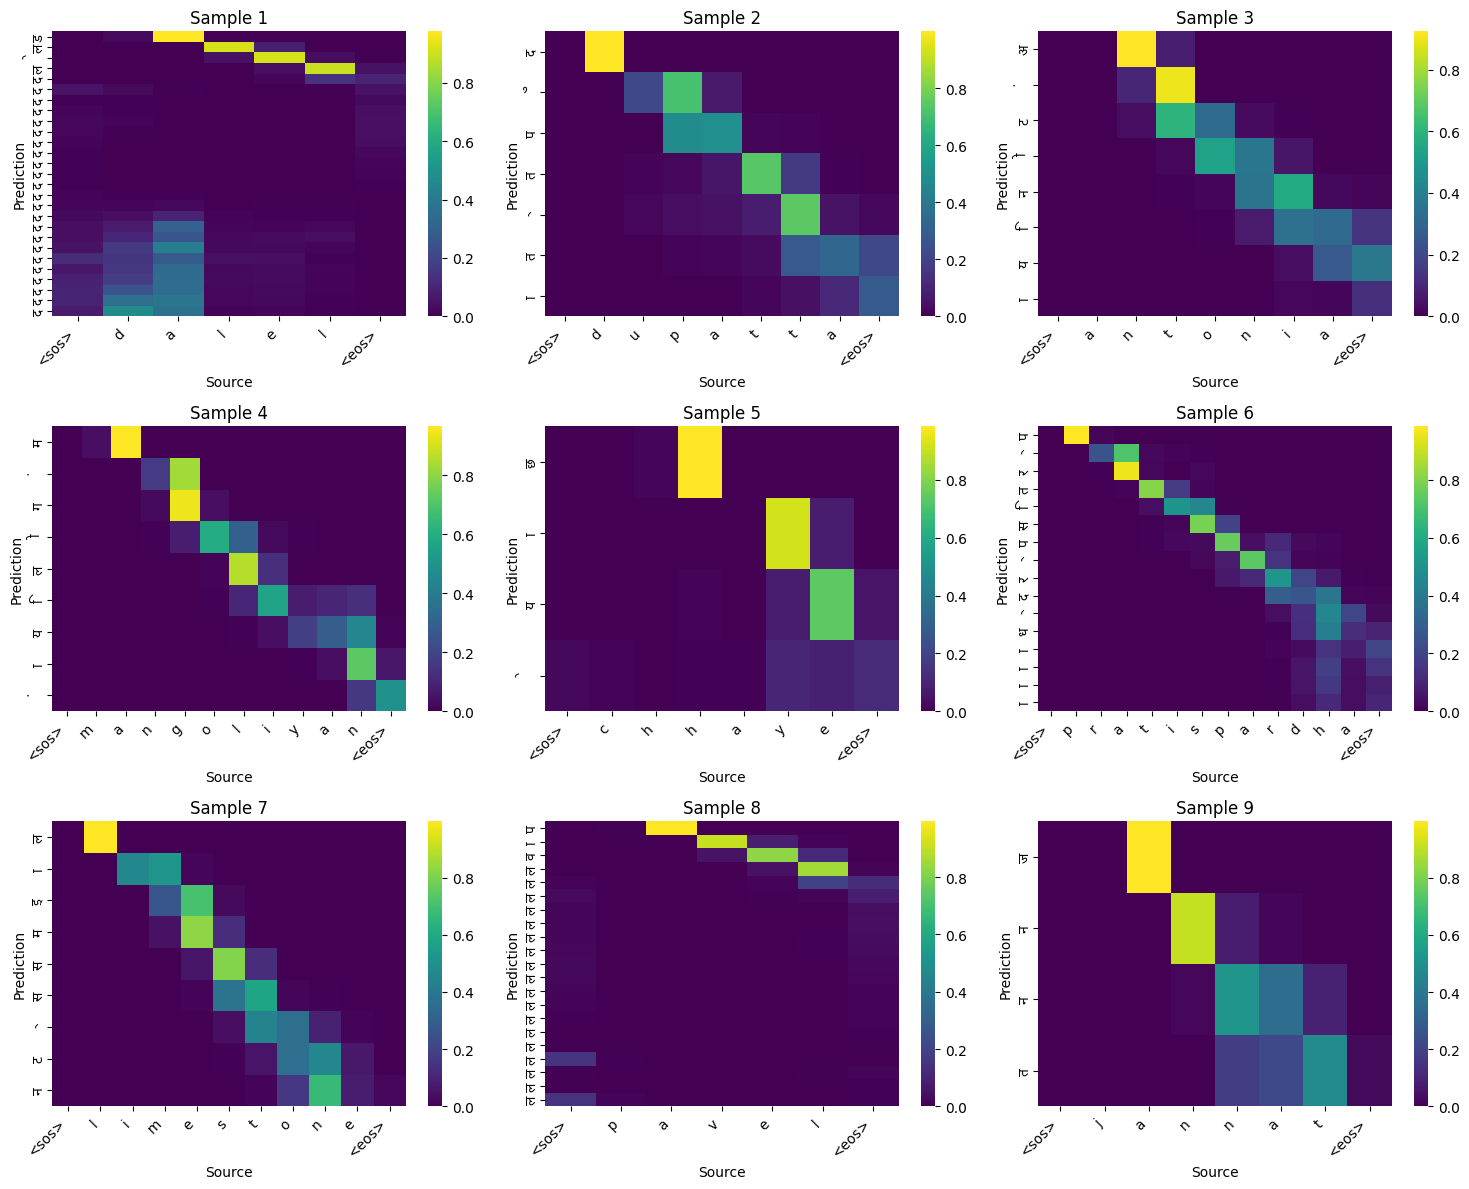

In [39]:
import warnings
warnings.filterwarnings("ignore")

train_loader, dev_loader, src_vocab, tgt_vocab = load_data()
_, test_loader, src_vocab, tgt_vocab, test_df = load_combined_data()
input_vocab_size = len(src_vocab)
target_vocab_size = len(tgt_vocab)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
src_vocab_inv = invert_vocab(src_vocab)
tgt_vocab_inv = invert_vocab(tgt_vocab)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_config = {
    'embedding_dim': 16,
    'hidden_size': 256,
    'encoder_layers': 3,
    'decoder_layers': 3,
    'cell_type': 'LSTM',
    'dropout': 0.31,
    'epochs': 10,
    'batch_size': 32
}
model = AttnSeq2SeqModel(input_vocab_size=input_vocab_size,
                         target_vocab_size=target_vocab_size,
                         embedding_dim=best_config['embedding_dim'],
                         hidden_size=best_config['hidden_size'],
                         cell_type=best_config['cell_type'],
                         dropout=best_config['dropout']).to(device)  # load your trained model here

model.load_state_dict(torch.load("/kaggle/input/attention-model/pytorch/default/1/best_model_attention_based.pth", map_location=device))
model.to(device)

visualize_attention_grid(model, dev_loader.dataset, src_vocab, tgt_vocab, src_vocab_inv, tgt_vocab_inv, device)

# Interactive connectivity analysis of the model

In [40]:
import torch
import numpy as np

def extract_attention_samples(model, dataset, src_vocab_inv, tgt_vocab_inv, device, num_samples=3):
    model.eval()
    samples = []

    indices = torch.randperm(len(dataset))[:num_samples]
    for idx in indices:
        src_seq_tensor, _ = dataset[idx.item()]
        src_seq_tensor = src_seq_tensor.unsqueeze(0).to(device)

        pred_seq, attn_weights = model.predict_with_attention(src_seq_tensor, tgt_vocab)

        src_seq = src_seq_tensor[0].tolist()
        pred_seq = pred_seq[0].tolist()
        src_tokens = [src_vocab_inv[i] for i in src_seq if i != src_vocab[PAD_TOKEN]]
        tgt_tokens = [tgt_vocab_inv[i] for i in pred_seq if i not in {tgt_vocab[PAD_TOKEN], tgt_vocab[EOS_TOKEN]}]
        attn_matrix = attn_weights.squeeze(0)[:len(tgt_tokens), :len(src_tokens)].detach().cpu().numpy()

        samples.append({
            'src_tokens': src_tokens,
            'tgt_tokens': tgt_tokens,
            'attention': attn_matrix.tolist()  # make JSON-serializable
        })

    return samples

def extract_attention_samples(model, dataset, src_vocab_inv, tgt_vocab_inv, device, num_samples=3):
    model.eval()
    samples = []
    sample_indices = torch.randperm(len(dataset))[:num_samples]

    for idx in sample_indices:
        src_seq_tensor, _ = dataset[idx.item()]
        src_seq_tensor = src_seq_tensor.unsqueeze(0).to(device)
        pred_seq, attn_weights = model.predict_with_attention(src_seq_tensor, tgt_vocab)

        src_seq = src_seq_tensor[0].tolist()
        pred_seq = pred_seq[0].tolist()

        src_tokens = [src_vocab_inv[i] for i in src_seq if i != src_vocab[PAD_TOKEN]]
        tgt_tokens = [tgt_vocab_inv[i] for i in pred_seq if i not in {tgt_vocab[EOS_TOKEN], tgt_vocab[PAD_TOKEN]}]
        attn_matrix = attn_weights.squeeze(0).detach().cpu().numpy()

        samples.append({
            "src_tokens": src_tokens,
            "tgt_tokens": tgt_tokens,
            "attention": attn_matrix[:len(tgt_tokens), :len(src_tokens)].tolist()
        })

    return samples


In [26]:
import wandb
wandb.login(key="011c3a6cd3743b4b10442ed458038feb25f78ad6")  # Revoke after testing

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mm21b010 (mm21b010-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [56]:
import wandb
import json

def create_attention_html(samples):
    html_parts = []
    for idx, sample in enumerate(samples):
        src = sample["src_tokens"]
        tgt = sample["tgt_tokens"]
        attn = sample["attention"]
        
        src_js = json.dumps(src, ensure_ascii=False)
        tgt_js = json.dumps(tgt, ensure_ascii=False)
        attn_js = json.dumps(attn)

        html_parts.append(f"""
        <div class="sample-container" style="margin-bottom: 50px;">
            <h4>Sample {idx + 1}</h4>
            <div>
                <strong>Input:</strong>
                <div id="input-text-{idx}" style="font-family: monospace; font-size: 20px; letter-spacing: 5px;">
                    {' '.join([f'<span class="input-char" data-index="{i}" style="padding: 2px; border-radius: 3px;">{char}</span>' for i, char in enumerate(src)])}
                </div>
            </div>
            <div style="margin-top: 15px;">
                <strong>Output:</strong>
                <div id="output-text-{idx}" style="font-family: 'Noto Sans Devanagari', sans-serif; font-size: 24px;">
                    {''.join([f'<span class="output-char" data-index="{i}" style="padding: 2px; cursor: pointer;">{char}</span>' for i, char in enumerate(tgt)])}
                </div>
            </div>
            <script>
            (function() {{
                const attentionData = {attn_js};
                const inputChars = document.querySelectorAll('#input-text-{idx} .input-char');
                const outputChars = document.querySelectorAll('#output-text-{idx} .output-char');

                function applyAttention(tgtIndex) {{
                    const weights = attentionData[tgtIndex];
                    const maxWeight = Math.max(...weights);

                    inputChars.forEach((char, i) => {{
                        const w = weights[i];
                        const opacity = (w / maxWeight).toFixed(2);
                        const rgba = 'rgba(0, 102, 255, ' + opacity + ')';
                        char.style.backgroundColor = rgba;
                    }});
                }}

                function clearAttention() {{
                    inputChars.forEach(char => {{
                        char.style.backgroundColor = '';
                    }});
                }}

                outputChars.forEach((char, i) => {{
                    char.addEventListener('mouseenter', () => {{
                        applyAttention(i);
                        char.style.backgroundColor = 'rgba(255, 215, 0, 0.3)';
                    }});
                    char.addEventListener('mouseleave', () => {{
                        clearAttention();
                        char.style.backgroundColor = '';
                    }});
                }});
            }})();
            </script>
        </div>
        """)

    return f"""
    <!DOCTYPE html>
    <html>
    <head>
        <meta charset="UTF-8">
        <title>Attention Visualization</title>
        <style>
            body {{
                font-family: Arial, sans-serif;
                margin: 20px;
                line-height: 1.6;
            }}
            .input-char {{
                transition: background-color 0.2s ease;
            }}
            .output-char {{
                transition: background-color 0.2s ease;
            }}
            .sample-container {{
                border-bottom: 1px solid #ddd;
                padding-bottom: 30px;
            }}
        </style>
        <!-- Devanagari font load -->
        <link href="https://fonts.googleapis.com/css2?family=Noto+Sans+Devanagari&display=swap" rel="stylesheet">
    </head>
    <body>
        <h2>Interactive Attention Visualization</h2>
        <p>Hover over Devanagari characters to see attention weights on the Latin input text.</p>
        {''.join(html_parts)}
    </body>
    </html>
    """

# Extract attention samples
# samples = extract_attention_samples(model, dev_loader.dataset, src_vocab_inv, tgt_vocab_inv, device, num_samples=3)

# # Generate the interactive HTML
# html_content = create_attention_html(samples)

# # Log to Weights & Biases
# wandb_project = "dakshina-transliteration"
# with wandb.init(project=wandb_project, name="attention_overlay") as run:
#     wandb.log({"attention_overlay": wandb.Html(html_content, inject=False)})


# Example usage
samples = extract_attention_samples(model, dev_loader.dataset, src_vocab_inv, tgt_vocab_inv, device, num_samples=10)
html_content = create_attention_html(samples)

wandb_project = "dakshina-transliteration"
with wandb.init(project=wandb_project, name="attention_final") as run:
    wandb.log({"attention_final": wandb.Html(html_content, inject=False)})